# Training and Testing an MDRNN on Synthetic Data

This script trains and tests a mixture density recurrent neural network (MDRNN) on synthetic performances.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import sketch_mdn

## Generating Fake data:

The idea is to generate some data that "could" have been human, but has a regular pattern. The time axis is sampled from a normal distribution with the same mean and S.D. as the human corpus. The value axis is generated by applying regular signal functions (e.g., sine, square, triangle) to this time axis.


                 dt       seconds         value
count  15000.000000  15000.000000  1.500000e+04
mean       0.149800   1130.739531  4.963149e-01
std        0.113389    651.546552  3.539320e-01
min        0.000014      0.155799  4.556383e-09
25%        0.060442    561.259035  1.425794e-01
50%        0.126483   1136.002855  4.961937e-01
75%        0.216607   1698.627179  8.483939e-01
max        0.789639   2246.996445  1.000000e+00


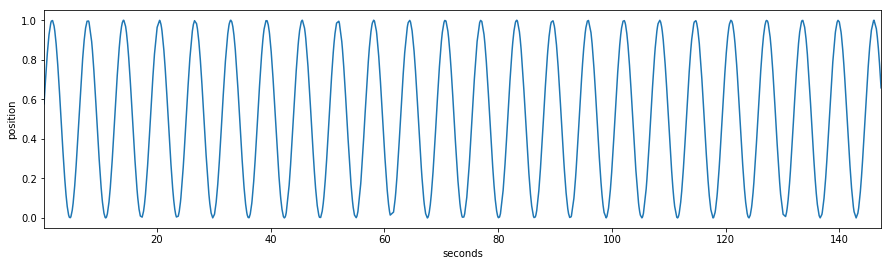

In [3]:
# Generate fake Sine movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

sine_df = pd.DataFrame({'dt' : t_diffs})
sine_df.dt = sine_df.dt.abs()
sine_df['seconds'] = sine_df.dt.cumsum()
sine_df['value'] = (np.sin(sine_df.seconds) * 0.5) + 0.5
print(sine_df.describe())

ax = sine_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('sine_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('sine_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': sine_df.dt, 'x': sine_df.value})
sine_corpus = np.array(corpus_df)

                 dt       seconds         value
count  15000.000000  15000.000000  15000.000000
mean       0.149698   1116.979977      0.496267
std        0.113594    647.780209      0.500003
min        0.000016      0.122166      0.000000
25%        0.058646    554.242890      0.000000
50%        0.126157   1112.406947      0.000000
75%        0.216148   1675.053754      1.000000
max        0.829259   2245.465522      1.000000


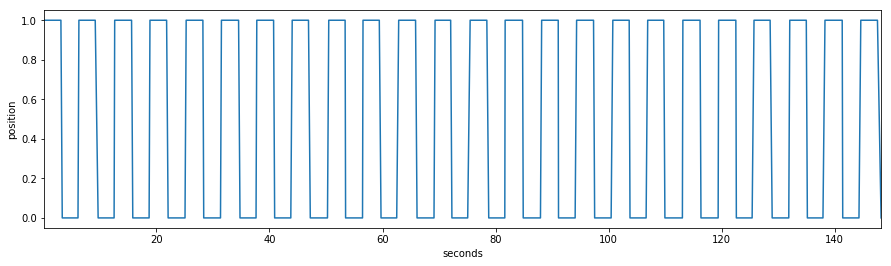

In [4]:
# Generate fake Squarey Movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

square_df = pd.DataFrame({'dt' : t_diffs})
square_df.dt = square_df.dt.abs()
square_df['seconds'] = square_df.dt.cumsum()
square_df['value'] = (scipy.signal.square(square_df.seconds) * 0.5) + 0.5
print(square_df.describe())

ax = square_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('square_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('square_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': square_df.dt, 'x': square_df.value})
square_corpus = np.array(corpus_df)

                 dt       seconds         value
count  15000.000000  15000.000000  15000.000000
mean       0.152230   1142.364349      0.500061
std        0.114707    660.821759      0.288481
min        0.000008      0.375040      0.000072
25%        0.060611    568.566153      0.249196
50%        0.128839   1143.985764      0.504137
75%        0.219459   1715.980665      0.749895
max        0.743043   2283.442602      0.999663


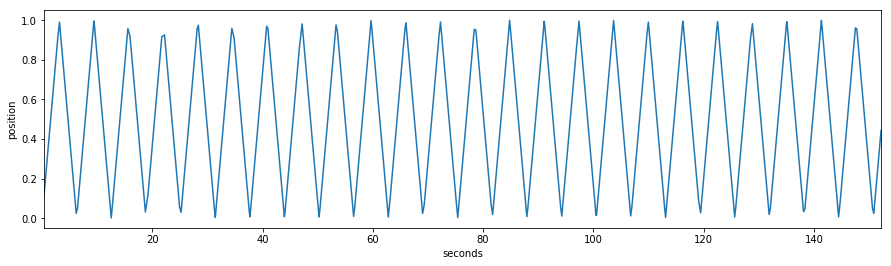

In [5]:
# Generate fake triangle-y Movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

tri_df = pd.DataFrame({'dt' : t_diffs})
tri_df.dt = tri_df.dt.abs()
tri_df['seconds'] = tri_df.dt.cumsum()
tri_df['value'] = (scipy.signal.sawtooth(tri_df.seconds, width=0.5) * 0.5) + 0.5
print(tri_df.describe())

ax = tri_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('tri_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('tri_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': tri_df.dt, 'x': tri_df.value})
tri_corpus = np.array(corpus_df)

# Train networks with the Synthetic data

Training an MDN with these synthetic data sets.

### Here are the corpora

- square_corpus
- tri_corpus
- sine_corpus

INFO:tensorflow:Loading Training Operations
INFO:tensorflow:done initialising: mixture-rnn-1layers-256units vars: 277552
Total training examples: 14878
Done initialising loader.
INFO:tensorflow:going to train: mixture-rnn-1layers-256units
INFO:tensorflow:trained epoch 0 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-1layers-256units-20180419-142921/mixture-rnn-1layers-256units.ckpt, global_step 148.
INFO:tensorflow:trained epoch 1 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-1layers-256units-20180419-142921/mixture-rnn-1layers-256units.ckpt, global_step 296.
INFO:tensorflow:trained epoch 2 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-1layers-256units-20180419-142921/mixture-rnn-1layers-256units.ckpt, global_step 444.
INFO:tensorflow:trained epoch 3 of 10
INFO:tensorflow:saving model ./output-logs/mixture-rnn-1layers-256units-20180419-142921/mixture-rnn-1layers-256units.ckpt, global_step 592.
INFO:tensorflow:trained epoch 4 of 10
INFO:tensor

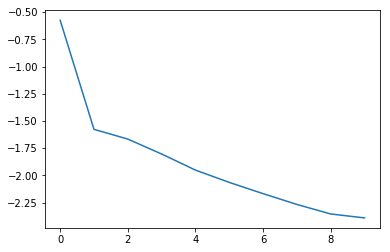

In [6]:
# Hyperparameters
units = 256
mixes = 8
layers = 1
batch_s = 100
n_steps = 120
epochs = 10

# Train
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_TRAIN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)
loader = sketch_mdn.SequenceDataLoader(num_steps=(n_steps + 1), batch_size=batch_s, corpus=tri_corpus)
losses = net.train(loader, epochs, saving=True)
## Plot the losses.
plt.plot(losses)
plt.show()

## Investigate some generated data:



INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mixture-rnn-1layers-128units vars: 73264
Test Input: [ 0.00964031  0.79572793]
INFO:tensorflow:Restoring parameters from ./mixture-rnn-1layers-128units
Test Output:
                dt        value      seconds
count  2001.000000  2001.000000  2001.000000
mean      0.146117     0.440205   148.674894
std       0.119128     0.228251    82.471512
min       0.000454     0.000000     0.009640
25%       0.061826     0.254431    77.553489
50%       0.127177     0.426854   148.934485
75%       0.203147     0.607957   220.600747
max       1.478957     1.000000   292.379144


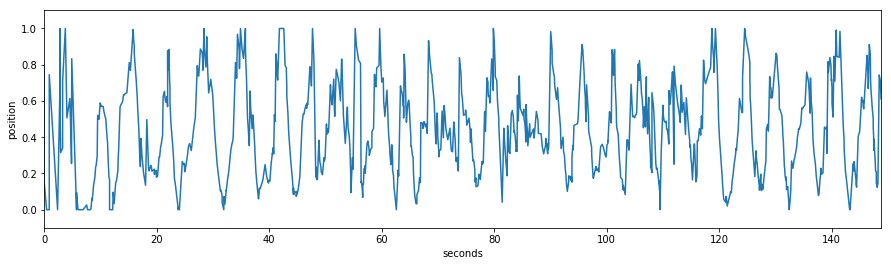

In [7]:
# Hyperparameters
units = 128
mixes = 8
layers = 1
batch_s = 1
n_steps = 1

# Instantiate Running Network
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_RUN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)

first_touch = np.array([(0.01 + (np.random.rand()-0.5)*0.005), np.random.rand()])
print("Test Input:",first_touch)

with tf.Session() as sess:
    perf = net.generate_performance(first_touch,2000,sess)
print("Test Output:")
perf_df = pd.DataFrame({'dt':perf.T[0], 'value':perf.T[1]})
perf_df['seconds'] = perf_df.dt.cumsum()

print(perf_df.describe())

ax = perf_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.set_ylim([-0.1,1.1])
ax.get_figure().savefig('synth_net_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('synth_net_output.png', dpi=300, bbox_inches="tight")

# #plt.show(perf_df.plot('time','x',kind='scatter'))
# plt.plot(perf_df.time, perf_df.x, '.r-')
# plt.show()
# 

# ## Investigate Output
# window = 100
# for n in [1000,2000,3000,4000,5000,6000]:
#     print("Window:", str(n),'to',str(n+window))
#     plt.plot(perf_df[n:n+window].time, perf_df[n:n+window].x, '.r-')
#     plt.show()

# input_touch = first_touch.reshape([1,1,net.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
# if net.state is not None:
#     feed = {net.x: input_touch, net.init_state: net.state}
# else:
#     feed = {net.x: input_touch}
# pis, locs_1, locs_2, scales_1, scales_2, corr, net.state = sess.run([net.pis, net.locs_1, net.locs_2, net.scales_1, net.scales_2,  net.corr, net.final_state], feed_dict=feed)
# #x_1, x_2 = sketch_mixture.sample_mixture_model(pis, locs_1, locs_2, scales_1, scales_2, corr, temp=1.0, greedy=False)




In [ ]:

ax = perf_df[:1000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.set_ylim([-0.1,1.1])
ax.get_figure().savefig('synth_net_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('synth_net_output.png', dpi=300, bbox_inches="tight")

